# $H \rightarrow ZZ \rightarrow 4\ell$ Classification with a BDT
 >__Created__:  October 08 2022 ASP 2022 South Africa, Harrison B. Prosper<br>
 >__Updated__: March 19 2023 for CLASHEP 2023, San Esteban, Chile<br>
 >__Updated__: June 28 2023 for Terascale 2023, DESY, Hamburg, Germany
 
 
## Task
Use a boosted decision tree (BDT) to discriminate between Higgs boson events produced via vector boson fusion from events pr
oduced via gluon gluon fusion using the di-jet mass $m_{jj}$ (massjj) and the di-jet separation $|\Delta\eta_{jj}|$ (detajj) in pseudo-rapidity. 

## Introduction
We use the __AdaBoost__ algorithm to train a BDT to discriminate between Higgs boson production via vector boson fusion (__vbf__) and production via gluon gluon fusion (__ggf__).

### The AdaBoost Algorithm

In 1997, AT&T researchers Freund and Schapire[1] published an algorithm called AdaBoost that produced highly effective classifiers by combining many decision trees. AdaBoost was the first successful method to boost (i.e., enhance) the performance of poorly performing classifiers (called *weak learners*) by averaging their outputs:

\begin{align}
f(x, \omega) &= \sum_{k=1}^{K} a_k \, T(x, \omega_k),
\end{align}
where $T(x, \omega_k)$ are decision trees. A sequence of decision trees is constructed using $N$ weighted events with weights which, initially, sum to one. The classifier $f(x, \omega)$ based on the first $k$ trees is used to classify the events. If an event is misclassified its weight is increased relative to the weights of correctly classified events. A new tree is created using the same events, but with the updated weights.

![AdaBoost](AdaBoost.png)

The above algorithm is rather cryptic. However, as discussed below, it is mathematically equivalent to minimizing a particular average loss.

### References
  1. Y. Freund and R. E. Schapire, Journal of Computer and Sys. Sci. 55 (1), 119 (1997)

  1. esc Y to go to code mode
  1. esc M to go to markdown mode

In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, plot_tree

# standard measures of model performance
from sklearn.metrics import roc_curve, auc

import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

### Load simulated $H \rightarrow ZZ \rightarrow 4\ell$ data 


#### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.


In [2]:
columns = ['detajj', 'massjj', 'target']

train   = pd.read_csv('../data/hzz4l_train.csv.gz', usecols=columns)

valid   = pd.read_csv('../data/hzz4l_valid.csv.gz', usecols=columns)

test    = pd.read_csv('../data/hzz4l_test.csv.gz',  usecols=columns)

# +1 for vbf, -1 for ggf
train['target'] = 2*train['target']-1
valid['target'] = 2*valid['target']-1
test['target']  = 2*test['target']-1

print(len(train), len(valid), len(test))

train[:10]

50000 10000 10000


,massjj,detajj,target
0,64.72,0.8003,-1.0
1,295.90,3.8210,1.0
2,167.30,0.0860,-1.0
3,1973.00,7.1430,1.0
4,90.04,0.8111,-1.0
5,109.60,2.2020,-1.0
6,258.60,2.8240,1.0
7,265.10,2.8690,-1.0
8,201.20,3.5180,-1.0
9,841.50,4.9010,1.0


### Approximate $p(t=1 | \boldsymbol{x}) \equiv p(\textrm{vbf} | \boldsymbol{x})$ using histograms

Let H$_{VBF}$ and H$_{ggf}$ be the 2D histograms of vbf and ggf events, respectively. We can approximate  $p(\textrm{vbf} | \boldsymbol{x})$  as follows
\begin{align}
p(\textrm{vbf} | \boldsymbol{x}) &\approx \frac{\textrm{H}_\text{vbf}}{\textrm{H}_\text{vbf} + \textrm{H}_\text{ggf}}
\end{align}

__Note__:
    
  * $x = (m_{jj}, |\Delta\eta_{jj}|)$
  * $t = 1$ for vbf events, $t = -1$ for ggf events

In [3]:
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

XBINS =   8
XMIN  =   0
XMAX  =   8
XSTEP =   2

YBINS =   8
YMIN  =   0
YMAX  =2000
YSTEP = 500

inputs  = [XNAME, YNAME]

train_x = train[inputs]
train_t = train['target']

valid_x = valid[inputs]
valid_t = valid['target']

test_x  = test[inputs]
test_t  = test['target']

In [4]:
# split training data into vbf and ggF events

VBF = train['target'] > 0.5
sig = train[VBF]

GGF = train['target'] < 0.5
bkg = train[GGF]

s, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                   bins=(XBINS, YBINS), 
                                   range=((XMIN, XMAX), 
                                          (YMIN, YMAX)))

b, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                   bins=(XBINS, YBINS), 
                                   range=((XMIN, XMAX), 
                                          (YMIN, YMAX)))

# get bin centers and create a meshgrid 
x    = (xedges[:-1]+xedges[1:])/2
y    = (yedges[:-1]+yedges[1:])/2
x, y = np.meshgrid(x, y)

# protect against s + b <= 0
d = np.where(s + b <= 0, 1e10, s + b)

# approximate z = p(t=+1|data) and cache x, y, z in the 3-tuple H
# WARNING: must transpose z so that x, y, and z have the
# same shape. 
z = (s / d).T
H = (x, y, z)

# choose a subset of test data to plot
K = 8000
t = test[:K]

VBF = t['target'] > 0.5
sig = t[VBF]

GGF = t['target'] < 0.5
bkg = t[GGF]

print(len(sig), len(bkg), len(sig)+len(bkg))

4021 3979 8000


### Plot contours of $p(t = 1| x) \equiv p(\text{vbf} | x)$, where $x = (|\Delta\eta_{jj}|, m_{jj})$

Note: __matplotlib__ has two graphics systems: 1) function-based and 2) object-based. The function below illustrates the object-based system.

In [5]:
def plot_data(sig, bkg, h=None,
              xname=XNAME, yname=YNAME, 
              xlabel=XLABEL, ylabel=YLABEL,
              xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
              filename='hzz4l_sig_vs_bkg.png',
              fgsize=(5, 5), 
              alpha=0.2,
              contour_colors='rainbow',
              bdt_colors='rainbow',
              ftsize=FONTSIZE, 
              bdt=None):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='vbf')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggf')
    
    # optional add BDT bins
    if bdt:
        bdt.plot2D(itree, ax, 
                   colormap=bdt_colors, 
                   alpha=alpha)
    else:
        ax.grid()
        
    if h:
        x, y, z = h
        mylevels = np.arange(0.5, 1, 0.1) 
        
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               cmap=contour_colors)
    
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='cyan')
    
    ax.legend(loc='upper left') # activate legend
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_detajj_massjj.png


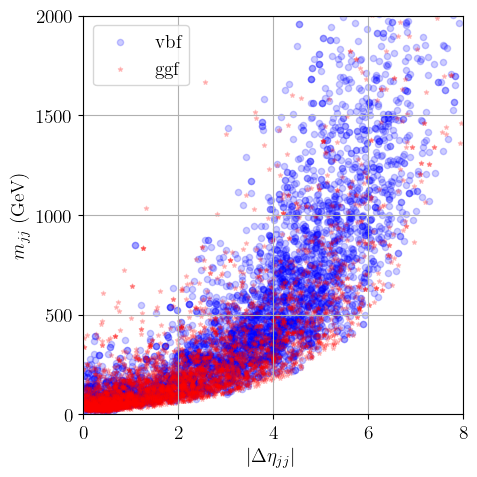

hzz4l_detajj_massjj_with_contours.png


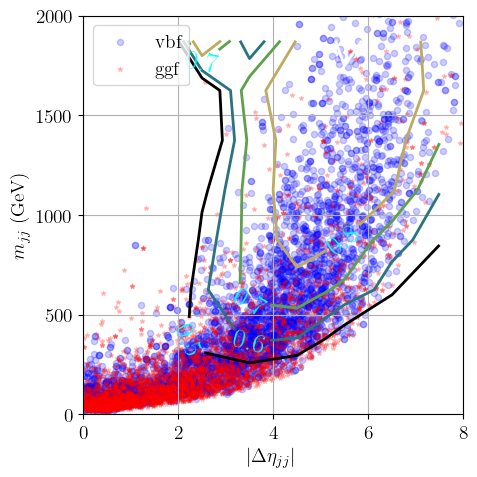

In [6]:
plot_data(sig, bkg, 
          filename='hzz4l_%s_%s.png' % (XNAME, YNAME), 
          ftsize=14,
          contour_colors='gist_earth')

plot_data(sig, bkg, H,
          filename='hzz4l_%s_%s_with_contours.png' % (XNAME, YNAME), 
          ftsize=14,
          contour_colors='gist_earth')

### Train boosted decision tree classifier

In [7]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                                                #min_samples_leaf=M),
                         algorithm="SAMME", 
                         n_estimators=100)

print("Training...")
bdt.fit(train_x, train_t)

print(f"Training   score: {bdt.score(train_x, train_t):10.3f}")      
print(f"Validation score: {bdt.score(valid_x, valid_t):10.3f}")

Training...
Training   score:      0.701
Validation score:      0.695


### Load BDT wrapper class 

This Python class was adapted from one developed for TMVA many years ago.

For each leaf:
  * bweight: background fraction relative to sample size
  * sweight: signal fraction relative to sample size
  * value:   -1 or +1 for original AdaBoost algorithm


tree number 0	weight =  8.429e-01
   ROOT      massjj     310.65
  -- LEFT      massjj     111.85
  ---- LEFT      massjj      59.24
  ------ LEFT      detajj       0.82
  -------- LEFT      massjj      34.05
  ---------- LEFT      massjj      31.14
  ------------ LEFT  BKG   1.92e-02   3.54e-03      -1.00
  ------------ RIGHT BKG   5.64e-03   4.80e-04      -1.00
  ---------- RIGHT     detajj       0.03
  ------------ LEFT  BKG   1.38e-03   6.40e-04      -1.00
  ------------ RIGHT BKG   3.62e-02   8.92e-03      -1.00
  -------- RIGHT     massjj      36.30
  ---------- LEFT      detajj       0.95
  ------------ LEFT  BKG   1.48e-03   1.20e-04      -1.00
  ------------ RIGHT BKG   1.62e-03   0.00e+00      -1.00
  ---------- RIGHT     massjj      37.98
  ------------ LEFT  BKG   4.80e-04   1.80e-04      -1.00
  ------------ RIGHT BKG   1.57e-02   1.98e-03      -1.00
  ------ RIGHT     detajj       1.77
  -------- LEFT      massjj      86.47
  ---------- LEFT      detajj       0.92
  ----

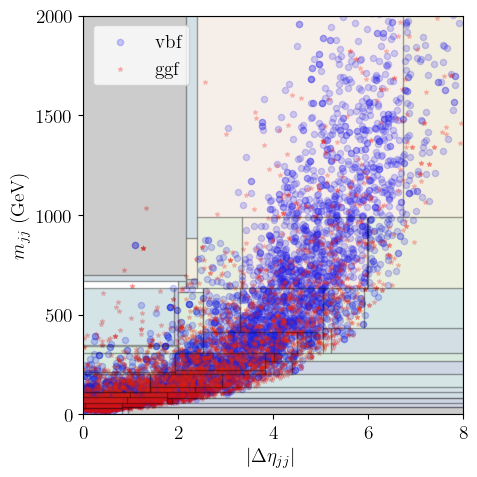

In [8]:
import bdtutil as bd

bdtree = bd.BDT(bdt)

itree = 0
bdtree.printTree(itree)

plot_data(sig, bkg,
          fgsize=(5, 5),
          filename='hzz4l_%s_%s_tree0.png' % (XNAME, YNAME), 
          bdt=bdtree, 
          bdt_colors='gist_earth')

In [9]:
def plot_trees(bdt, 
               xname=XNAME, yname=YNAME, 
               xlabel=XLABEL, ylabel=YLABEL,
               xmin=XMIN, xmax=XMAX, xstep=XSTEP,
               ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
               filename='hzz4l_trees.png',
               fgsize=(8, 5), 
               alpha=0.2, colormap='gist_earth',
               ftsize=FONTSIZE):
    
    # make room for 6 sub-plots
    n_rows = 2
    n_cols = 3
    fig, axs = plt.subplots(nrows=n_rows, 
                            ncols=n_cols, 
                            figsize=fgsize)
    
    kk =-1
    for ii, ax in enumerate(axs.flatten()):
        jj = ii % n_cols
        if jj == 0:
            kk += 1
            
        # annotate axes
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if jj == 0:
            ax.set_ylabel(ylabel, fontsize=ftsize)
            ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
            
        if kk+1 == n_rows:
            ax.set_xlabel(xlabel, fontsize=ftsize)
            ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
        bdt.plot2D(ii, ax, 
                   colormap=colormap, 
                   alpha=alpha)
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_trees.png


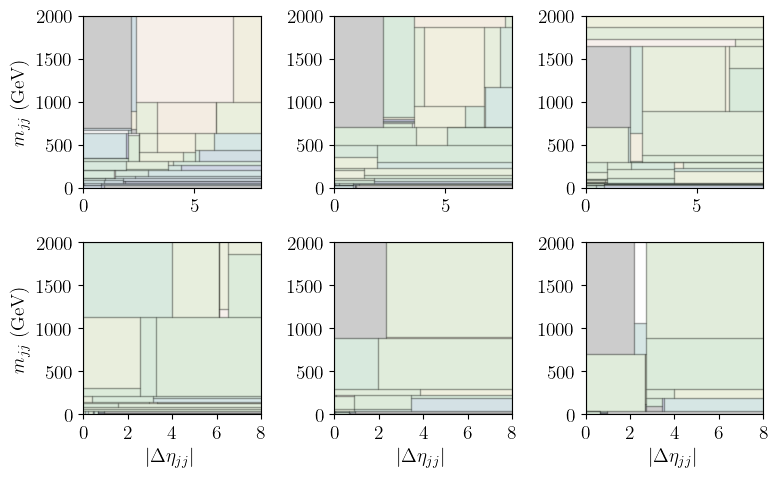

In [10]:
plot_trees(bdtree, colormap='gist_earth')

### Compare calculations between bdtree and (scikit-learn) BDT
The calculation of the AdaBoost decision function in scikit-learn is incorrect! Here we compute it correctly using the BDT wrapper, *bdtree*.

In [11]:
x   = test_x[:10]
print(x)
print()

print('using scikit-learn definition of decision function')
print('%10s %10s\t%10s %10s' % \
      ('bdtree', 'BDT', 'bdtree(p)', 'BDT(p)'))

Y1  = bdtree.decision_function(x, like_scikit_learn=True)
P1  = bdtree.predict_proba(x, like_scikit_learn=True)

Y2  = bdt.decision_function(x)
P2  = bdt.predict_proba(x).T[-1]

for y1, y2, p1, p2 in zip(Y1, Y2, P1, P2):
    print('%10.5f %10.5f\t%10.5f %10.5f' % \
          (y1, y2, p1, p2))
print()
print('using correct definition of decision function')
print('%10s %10s' % ('bdtree', 'bdtree(p)'))

Y1  = bdtree.decision_function(x)
P1  = bdtree.predict_proba(x)

for y1, p1 in zip(Y1, P1):
    print('%10.5f %10.5f' % (y1, p1))

   detajj  massjj
0  2.9680  208.50
1  4.6110  697.00
2  1.8730   96.73
3  2.0510  121.70
4  4.6680  452.70
5  2.8690  229.40
6  5.0940  660.50
7  1.6620   65.56
8  3.2640  415.40
9  0.5125   15.36

using scikit-learn definition of decision function
    bdtree        BDT	 bdtree(p)     BDT(p)
  -0.09681   -0.09681	   0.47582    0.47582
   0.31709    0.31709	   0.57861    0.57861
  -0.36643   -0.36643	   0.40941    0.40941
  -0.24306   -0.24306	   0.43953    0.43953
   0.11976    0.11976	   0.52991    0.52991
   0.05133    0.05133	   0.51283    0.51283
   0.14895    0.14895	   0.53717    0.53717
  -0.45435   -0.45435	   0.38833    0.38833
   0.14028    0.14028	   0.53501    0.53501
  -0.47080   -0.47080	   0.38443    0.38443

using correct definition of decision function
    bdtree  bdtree(p)
  -0.38707    0.40442
   1.26778    0.78036
  -1.46505    0.18770
  -0.97182    0.27452
   0.47884    0.61747
   0.20524    0.55113
   0.59554    0.64464
  -1.81659    0.13984
   0.56088    0.63666

### Plot contours of constant signal probability

Even though the __AdaBoost__ algorithm is rather cryptic, it is equivalent to an algorithm that minimizes the average exponential loss, $L = \exp(- t f / 2 )$, where the targets at $t = -1$ for ggF and $t= +1$ for VBF. Minimizing the average loss (for an infinite amount of data) requires solving

\begin{align}
    \int \frac{\partial L}{\partial f} \, p(t | x) \, dt & = 0,
\end{align}

to determine the mathematical expression approximated by the model $f(x, \omega)$ with free parameters $\omega$. When the above is solved for the exponential loss one concludes that the best fit model, $\hat{f}$ (determined with a *finite* data sample), approximates the optimal model 

\begin{align}
    f^* & =  \log \left[\frac{p(x | t = +1)}{p(x | t = -1)} \epsilon\right] ,
\end{align}

which can be rearranged as

\begin{align}
    p(t = +1 | x) & = \frac{1}{1 + \exp(- f^*)},\\
    & = \frac{p(x | t = +1) \, \epsilon}{p(x | t = +1) \, \epsilon + p(x | t = -1) } ,
\end{align}

where $\epsilon = \pi(t = +1) \, / \, \pi(t = -1)$ is the prior signal to background ratio, which in this example is 1.

In [12]:
def plot_contours(bdtree, sig, bkg, h=None, 
                  add_bdt_contours=False,
                  colormap='gist_earth',
                  numTrees=-1, 
                  xname=XNAME, yname=YNAME, 
                  xlabel=XLABEL, ylabel=YLABEL,
                  xmin=XMIN, xmax=XMAX, xstep=XSTEP,
                  ymin=YMIN, ymax=YMAX, ystep=YSTEP,
                  fgsize=(6, 5), 
                  alpha=0.5,
                  ftsize=FONTSIZE, 
                  filename='hzz4l_forest.png'):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='vbf')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggF')
    ax.legend(loc='upper left') # activate legend
    
    # superimpose a BDT contour plot
    # 1. first create a meshgrid
    # 2. compute network output at all mesh points
    npoints= 100
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin+xdelta/2, xmax, xdelta)
    yy     = np.arange(ymin+ydelta/2, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # compute model probability at every grid point
    # then reshape to an (npoints x npoints) array
    df = pd.DataFrame({xname: X.flatten(), yname: Y.flatten()})
    
    Z  = bdtree.predict_proba(df, numTrees).reshape([npoints, npoints])

    plt.imshow(Z, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=colormap)
    
    mylevels   = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    if add_bdt_contours:
        npoints= 8
        xdelta = float(xmax-xmin)/npoints
        ydelta = float(ymax-ymin)/npoints
        xx     = np.arange(xmin+xdelta/2, xmax, xdelta)
        yy     = np.arange(ymin+ydelta/2, ymax, ydelta)
        X2, Y2 = np.meshgrid(xx, yy)
        df     = pd.DataFrame({xname: X2.flatten(), 
                               yname: Y2.flatten()})
        
        Z2  = bdtree.predict_proba(df, numTrees,
                                   like_scikit_learn=False).reshape([npoints, 
                                                          npoints])

        cs = ax.contour(X2, Y2, Z2, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               linestyles='dashed',
               cmap=colormap)
    
    if h:
        x, y, z = h
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
                    cmap=colormap)
        plt.colorbar()
        
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='cyan')

    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

One sees that the boosted decision tree agrees with the probability contours approximated by histogramming.

hzz4l_forest.png


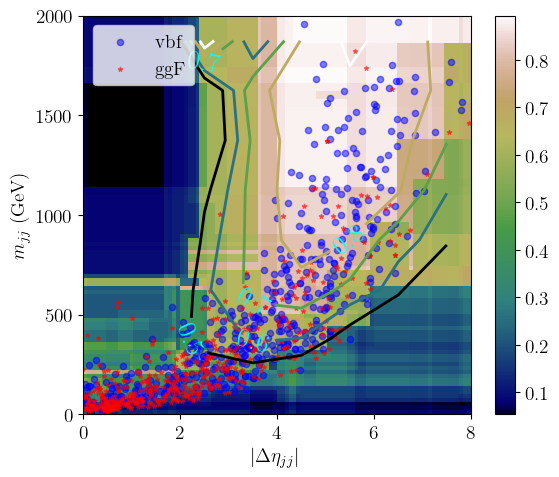

In [13]:
K = 500
ntrees = -1
plot_contours(bdtree, sig[:K], bkg[:K], h=H,
              numTrees=ntrees,
              add_bdt_contours=False,
              colormap='gist_earth')

### Plot ROC curve

In [14]:
test_y = bdtree.predict_proba(test_x)

In [20]:
def plot_distribution(y, t, 
                      nbins=50, 
                      ftsize=FONTSIZE, 
                      fgsize=(7, 5)):

    # select the model output results for vbf events
    vbf = y[t > 0.5]
    
    # select the model output results for ggf events
    ggf = y[t < 0.5]
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    plt.xlim(0, 1)
    plt.xlabel('$p(t=+1|data)$')
    plt.ylim(0, 5)
    
    plt.hist(ggf, 
             bins=nbins, 
             color=(1,0,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggf)') 
    plt.legend(fontsize='small')
    
    plt.hist(vbf, 
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (vbf)')
    plt.legend(fontsize='small')

    plt.savefig("hzz4l_dist_BDT.png")
    plt.show()

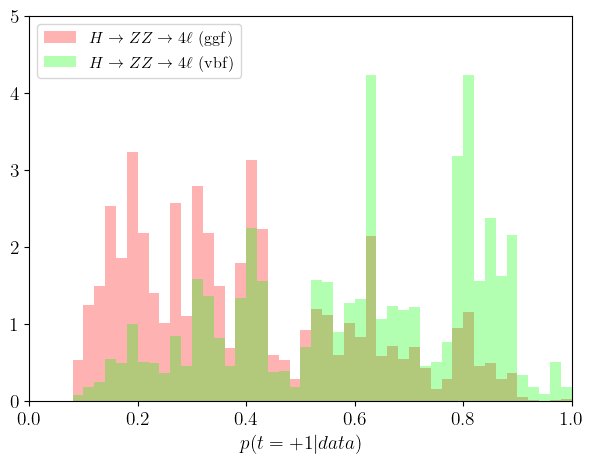

In [21]:
plot_distribution(test_y, test_t, nbins=50)

### Plot Receiver Operating Characteristic (ROC) curve
The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) was developed in the context of radar operations during World War II. It is a simple measure of the performance of a binary classifier. Recall the definition of the __right cumulative distribution function__

$$D_R(y) = \mathbb{P}(y > y_0).$$

When applied to the histograms above, $D_R(y)$ gives the fraction of events that remain when they are selected by applying the cut $y > y_0$ on the output $y$ of the classifier. The ROC curve is a plot of $D_R(y)$ for one class of objects versus $D_R(y)$ for the other class for different thresholds $y_0$. Another simple measure of performance, this time a global one, is the area under the ROC curve (AUC). 

If the histograms were identical the ROC curve would be a diagonal line of unit slope (see blue-dashed curve below) and the AOC would be 0.5. Borrowing some jargon from statistics, a classifier whose ROC curve dips below the diagonal line could justifiably be called *inadmissible*!

In [17]:
def plot_ROC(y, p):
    
    bad, good, _ = roc_curve(y, p)
    
    roc_auc = auc(bad, good)
    plt.figure(figsize=(5, 5))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('fraction of ggf events', fontsize=14)
    plt.ylabel('fraction of vbf events', fontsize=14)
    
    plt.plot(bad, good, color='red',
             lw=2, label='ROC curve, AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

    plt.legend(loc="lower right", fontsize=14)
    
    plt.savefig("hzz_ROC_BDT.png")
    plt.show()

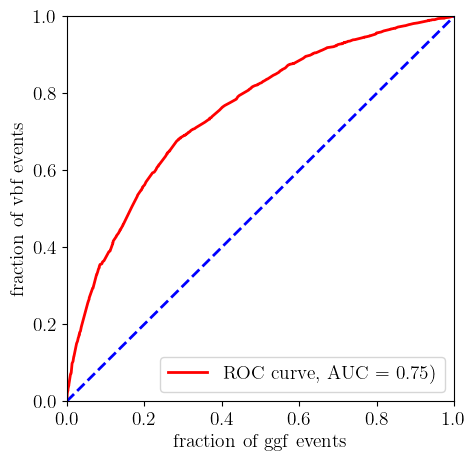

In [18]:
plot_ROC(test_t, test_y)